### Treefalls basic statistical analysis

The document descibes natural disturbances in stands caused by winds. We are trying to estimate the amount of such disturbances using different numerical measures, such as area of disturbances vs. geomorphological variables (height above sea level, slope, aspect, local gaussian curvature. 

### Configuration parameters

The section defines parameters that will allow to get access to the data: DEM and DEM-derived data, treefalls masked arrays.

In [1]:
import os
datadir = './data'
data_mapper = {'kunashir': {'box' : [4838720, 4935728, 369720, 468775], 
                            'data': {'height': 'kunUTM.tif',
                                     'curvature': 'vars_kun/Curvatu_kun.tif',
                                     'slope': 'vars_kun/Slope_kun.tif',
                                     'aspect': 'vars_kun/Aspect_kun.tif',
                                     'treefall': 'tiff_windfalls/windfalls_500m2_sakh_kur_Pol1.tif',
                                     'cover': 'forest_cover.tif',
                                     'biomass': 'biomass.tif'
                                    }
                                    },
               'sakhalin': {'box': [5086970, 5377762, 85000, 243321],
                            'data': {'height': 'sakhUTM.tif',
                            'curvature': 'vars_sakh/Curvatu.tif',
                            'slope': 'vars_sakh/Slope.tif',
                            'aspect': 'vars_sakh/Aspect.tif',
                            'treefall': 'tiff_windfalls/windfalls_500m2_sakh_kur_Pol1.tif',
                            'cover': 'forest_cover.tif',
                            'biomass': 'biomass.tif'
                                    }},
               'iturup': {'box': [4915354, 5004258, 488455, 556985],
                          'data':   {'height': 'kunUTM.tif',
                                     'curvature': 'vars_kun/Curvatu_kun.tif',
                                     'slope': 'vars_kun/Slope_kun.tif',
                                     'aspect': 'vars_kun/Aspect_kun.tif',
                                     'treefall': 'tiff_windfalls/windfalls_500m2_sakh_kur_Pol1.tif',
                                     'cover': 'forest_cover.tif',
                                     'biomass': 'biomass.tif'
                                    }},
               
#                 'shikotan': {'box': [4835160, 4862724, 467084, 494377],
#                              'data': {'height': 'kunUTM.tif',
#                                      'curvature': 'vars_kun/Curvatu_kun.tif',
#                                      'slope': 'vars_kun/Slope_kun.tif',
#                                      'aspect': 'vars_kun/Aspect_kun.tif',
#                                      'treefall': 'tiff_windfalls/windfalls_500m2_sakh_kur_Pol1.tif',
#                                      'cover': 'forest_cover.tif',
#                                      'biomass': 'biomass.tif'
#                                     }}
               } 

for key in data_mapper:
    for j in data_mapper[key]['data']:
        data_mapper[key]['data'][j] = os.path.join(datadir, data_mapper[key]['data'][j])


### Auxiliary functions

Here we define `gdal` based function used to perform basic i/o operations on spatial data. 

In [2]:
import numpy as np
from osgeo import gdal
from osgeo import osr

def array_to_raster(array, lats, lons,  outputfilename, asfname):
    """Array > Raster
    Save a raster from a C order array.

    :param array: ndarray
    """
    
    SourceDS = gdal.Open(asfname, gdal.GA_ReadOnly)
    Projection = osr.SpatialReference()
    Projection.ImportFromWkt(SourceDS.GetProjectionRef())    
    x_pixels, y_pixels = array.shape
    XPIXEL_SIZE = (lons[1] - lons[0]) / float(x_pixels)
    YPIXEL_SIZE = (lats[1] - lats[0]) / float(y_pixels)
    x_min = np.min(lons)
    y_max = np.max(lats)
    driver = gdal.GetDriverByName('GTiff')
    dataset = driver.Create(
        outputfilename,
        y_pixels,
        x_pixels,
        1,
        gdal.GDT_Float32)

    dataset.SetGeoTransform((
        x_min,    # 0
        abs(XPIXEL_SIZE),  # 1
        0,                      # 2
        y_max,    # 3
        0,                      # 4
        -abs(YPIXEL_SIZE)))
    dataset.SetProjection(Projection.ExportToWkt())
    dataset.GetRasterBand(1).WriteArray(array)
    dataset.FlushCache()  # Write to disk.
    return 0


def get_data_by_coordinate_np(lats, lons, array, xmin, xres, ymax, yres):
    """Just a helper function"""
    lat_inds = ((lats - ymax) / yres).astype(np.int16)
    lon_inds = ((lons - xmin) / xres).astype(np.int16)
    array = array[lat_inds, lon_inds]
    return array


def load_data(lats, lons, filename):
    data = gdal.Open(filename)
    geoinfo = data.GetGeoTransform()
    xmin = geoinfo[0]
    xres = geoinfo[1]
    ymax = geoinfo[3]
    yrot = geoinfo[4]
    xrot = geoinfo[2]
    yres = geoinfo[-1]
    if not np.isclose(xrot, 0) or not np.isclose(yrot, 0):
        raise BaseException("xrot and yrot should be 0")
    array = data.ReadAsArray()
    del data
    result = get_data_by_coordinate_np(np.array(lats, dtype=np.float64),
                                  np.array(lons, dtype=np.float64),
                                  array,
                                  xmin, xres, ymax, yres)
    return result


def create_grid(area, dlat=50, dlon=50):
    """Returns raw meshgrid based on specified discretization parameters
    """
    latmin, latmax, lonmin, lonmax = area
    lats = np.arange(latmin, latmax, dlat)
    lons = np.arange(lonmin, lonmax, dlon)
    return np.meshgrid(lats, lons)



### Functions for specific data loading

In [3]:
def load_specific_data(area='sakhalin', spec='treefall', dlat=70, dlon=70):
    """Loads data and return flattened array"""
    lats, lons = create_grid(data_mapper[area]['box'], dlat=dlat, dlon=dlon)
    data = load_data(lats, lons, data_mapper[area]['data'][spec])
    if spec == 'treefall':
        nodata_value = 255
        data[data==nodata_value] = 0
    return data, lats, lons
  

## Lets do some tests

In [4]:
import matplotlib.pyplot as plt

Explored area:  kunashir
(1416, 1386) (1416, 1386) (1416, 1386)


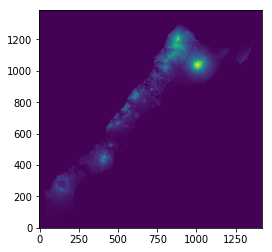

Explored area:  sakhalin
(2262, 4155) (2262, 4155) (2262, 4155)


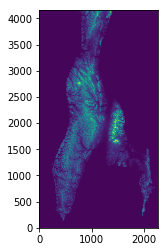

Explored area:  iturup
(979, 1271) (979, 1271) (979, 1271)


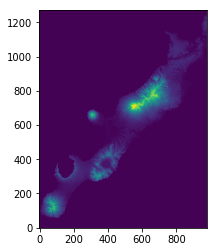

In [5]:
for area in data_mapper:
    print("Explored area: ", area)
    data, lats, lons = load_specific_data(area=area, spec='height')
    print(data.shape, lats.shape, lons.shape)
    plt.imshow(data.T, origin='lower')
    plt.show()

All tests are passed: we are ready to continue... 

### Area estimations, w/wo slope corrections

In [6]:
for area in data_mapper:
    print("========= {} ==============".format(area))
    slopes, lats, lons = load_specific_data(area=area, spec='slope')
    treefall, lats, lons = load_specific_data(area=area, spec='treefall')
    cover, lats, lons = load_specific_data(area=area, spec='cover')
    aspect, lats, lons = load_specific_data(area=area, spec='aspect')
    lat_size, lon_size = abs(lats[0][1] - lats[0][0]), abs(lons[1][0] - lons[0][0])
    all_data_indicies = ((aspect != -1) & (cover > 25))
    print("TreeFall area is sq. km: ", ((lat_size * lon_size)/np.cos(slopes[treefall == 1]/180*np.pi)).sum()/10**6)
    print("TreeFall area w/o slope correction, sq. km: ", (lat_size * lon_size*(treefall == 1).sum())/10**6)
    print("Total area is sq. km: ", ((lat_size * lon_size)/np.cos(slopes[all_data_indicies]/180*np.pi)).sum()/10**6)
    print("Total area w/o slope correction, sq. km: ", (lat_size * lon_size*(all_data_indicies).sum())/10**6)
    print("=" * 50)
    
    

========= kunashir ==============
TreeFall area is sq. km:  11.467949
TreeFall area w/o slope correction, sq. km:  11.221
Total area is sq. km:  1267.432576
Total area w/o slope correction, sq. km:  1222.6137
========= sakhalin ==============
TreeFall area is sq. km:  447.5976
TreeFall area w/o slope correction, sq. km:  426.5842
Total area is sq. km:  13126.598656
Total area w/o slope correction, sq. km:  12604.2014
========= iturup ==============
TreeFall area is sq. km:  9.608503
TreeFall area w/o slope correction, sq. km:  9.5697
Total area is sq. km:  1023.57792
Total area w/o slope correction, sq. km:  988.4084


In [7]:
## Make connectivity regions
from skimage.measure import label
from collections import Counter

for area in data_mapper:
    print("Evaluating area: ", area)
    treefall, lats, lons = load_specific_data(area=area, spec='treefall')
    slopes, lats, lons = load_specific_data(area=area, spec='slope')
    labels = label(treefall, connectivity=2, background=0) # Tree connectivity 
    res = []
    lat_size, lon_size = abs(lats[0][1] - lats[0][0]), abs(lons[1][0] - lons[0][0])
    for lab in np.unique(labels.ravel()):
        res.append((lat_size * lon_size / np.cos(slopes[labels == lab] / 180.0 * np.pi)).sum() / 10**6)
    res = np.sort(res)[:-1]
    plt.hist(res, bins=100)
    plt.gca().set_yscale('log')
    plt.gca().set_xlabel('area, km^2')
    plt.gca().set_ylabel('#num of patches')
    plt.title("Tree fall areas distribution")
    plt.savefig("%s_treefalls.png" % area, dpi=300)

Evaluating area:  kunashir
Evaluating area:  sakhalin
Evaluating area:  iturup


### Treefalls diagram vs. relief characteristics

In [8]:
from scipy.stats import ks_2samp
plt.rcParams.update({'font.size': 16})
for area in data_mapper:
    print("========= {} ==============".format(area))
    treefall, lats, lons = load_specific_data(area=area, spec='treefall')
    cover, lats, lons = load_specific_data(area=area, spec='cover')
    aspect, lats, lons = load_specific_data(area=area, spec='aspect')
    biomass, lats, lons = load_specific_data(area=area, spec='biomass')
    for var in ('height', 'aspect', 'slope'):
        data, lats, lons = load_specific_data(area=area, spec=var)
        all_data_indicies = ((aspect != -1) & (cover > 25)).ravel()
        tree_fall_indicies = (treefall == 1).ravel()
        plt.figure(figsize=(8, 6))
        plt.hist(data[treefall == 1], bins=50, normed=True, color='gray')
        plt.title("Area: {}".format(area))
        plt.gca().set_xlabel(str(var))
        y_data, x_spec = np.histogram(data.ravel()[all_data_indicies], bins=50, density=True)
        plt.gca().plot(x_spec[:-1], y_data, 'r')
        plt.savefig("%s_%s_histoogram.png" % (area, var), dpi=300)
        print("Statistical comparison to all points")
        
        # ------------ Select predefined number of points randomly ----------
        a, b = np.random.choice(data.ravel()[tree_fall_indicies], size=int(tree_fall_indicies.sum() * 0.7)), \
               np.random.choice(data.ravel()[all_data_indicies], size=int(tree_fall_indicies.sum() * 0.7)),  
        print("K-S test: ", ks_2samp(a, b))
        
        # ---------------- Biomass vs Parameters -----------------
        f = plt.figure()
        ax1 = f.add_subplot(121)
        ax2 = f.add_subplot(122)
        ax1.plot(data.ravel()[all_data_indicies], biomass.ravel()[all_data_indicies], '.')
        ax1.set_title("Original biomass distribution")
        ax2.plot(data.ravel()[tree_fall_indicies], biomass.ravel()[tree_fall_indicies], '.')
        ax2.set_title("Harvested biomass distribution")
        print("Harvested biomass total={}: mean={} +/- std={} ".format(biomass.ravel()[tree_fall_indicies].sum(), biomass.ravel()[tree_fall_indicies].mean(), biomass.ravel()[tree_fall_indicies].std()))
        print("Total biomass total={}: mean={} +/- std={} ".format(biomass.ravel()[all_data_indicies].sum(), biomass.ravel()[all_data_indicies].mean(), biomass.ravel()[all_data_indicies].std()))
        plt.savefig("%s_%s_biomass.png" % (area, var), dpi=300)
        print("=" * 50)


========= kunashir ==============


/home/dmitry/.pyenv/versions/3.5.4/envs/sci/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Statistical comparison to all points
K-S test:  Ks_2sampResult(statistic=0.33374922021210235, pvalue=1.1886800548574286e-78)
Harvested biomass total=336506: mean=146.94585152838428 +/- std=8.566342322219539 
Total biomass total=32981929: mean=132.18521279452372 +/- std=19.02999256348665 
Statistical comparison to all points
K-S test:  Ks_2sampResult(statistic=0.17903930131004364, pvalue=6.157277963845973e-23)
Harvested biomass total=336506: mean=146.94585152838428 +/- std=8.566342322219539 
Total biomass total=32981929: mean=132.18521279452372 +/- std=19.02999256348665 
Statistical comparison to all points
K-S test:  Ks_2sampResult(statistic=0.13786650031191516, pvalue=8.967470111825817e-14)
Harvested biomass total=336506: mean=146.94585152838428 +/- std=8.566342322219539 
Total biomass total=32981929: mean=132.18521279452372 +/- std=19.02999256348665 
========= sakhalin ==============


MemoryError: 

In [ ]:
## Make connectivity regions
from skimage.measure import label


for area in data_mapper:
    print("Evaluating area: ", area)
    treefall, lats, lons = load_specific_data(area=area, spec='treefall')
    slopes, lats, lons = load_specific_data(area=area, spec='slope')
    labels = label(treefall, connectivity=2)
    res = []
    lat_size, lon_size = abs(lats[0][1] - lats[0][0]), abs(lons[1][0] - lons[0][0])
    for lab in np.unique(labels.ravel()):
        res.append((lat_size*lon_size/np.cos(slopes[labels == lab])).sum())
    plt.hist(res, bins=50, normed=True)
    plt.title("Tree fall areas distribution")
    plt.savefig("%s_treefalls.png"%area, dpi=300)


In [ ]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.model_selection import cross_val_score, train_test_split
# from sklearn.decomposition import PCA

# for area in data_mapper:
#     print("========= {} ==============".format(area))
#     treefall, lats, lons = load_specific_data(area=area, spec='treefall')
#     data, lats, lons = load_specific_data(area=area, spec='aspect')
#     non_tree_fall_indicies = ((treefall != 1 ) & (data != -1)).ravel()
#     tree_fall_indicies = (treefall == 1).ravel()
#     # accumulate dataset 
#     X = []
#     y = np.hstack([[0] * non_tree_fall_indicies.sum(), [1] * tree_fall_indicies.sum()])
#     for var in ('height', 'aspect', 'slope'):
#         data, lats, lons = load_specific_data(area=area, spec=var)
#         _ = np.hstack([data.ravel()[non_tree_fall_indicies], data.ravel()[tree_fall_indicies]])
#         X.append(_.tolist())
#     X = np.array(X).T
#     model = LinearDiscriminantAnalysis().fit(X, y)
#     roc_auc = cross_val_score(model, X, y, cv=10, scoring='roc_auc')
#     print("ROC_AUC: mean={}, std={}".format(np.mean(roc_auc),np.std(roc_auc)))
#     accuracy = cross_val_score(model, X, y, cv=10, scoring='balanced_accuracy')
#     print("Accuracy: mean={}, std={}".format(np.mean(accuracy),np.std(accuracy)))
    
#     # Performing PCA projections
#     _, X_, _, y_ = train_test_split(X, y, stratify=y, test_size=0.01, random_state=0)
#     X_proj = PCA(n_components=2).fit_transform(X_)
#     plt.scatter(X_proj[y_==0, 0], X_proj[y_==0, 1], marker='o', color='r')
#     plt.scatter(X_proj[y_==1, 0], X_proj[y_==1, 1], marker='s', color='b')
#     plt.show()
#     print("=" * 50)